<a href="https://colab.research.google.com/github/stevenhobbs/5511_Deep_Learning/blob/main/Kaggle_Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histopathologic Cancer Detection
## [Kaggle Competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview)

### PURPOSE
The challenge of this competition is "to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates)."

### DATASET
The dataset is provided by Bas Veeling, Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak. The dataset is described in detail in their papers [*Rotation Equivariant CNNs for Digital Pathology*](https://arxiv.org/abs/1806.03962) and [*Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer*](https://jamanetwork.com/journals/jama/fullarticle/2665774).

## ANALYSIS
### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
from tqdm import tqdm
# import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

### Import Train Data

In [ ]:
df = pd.read_csv('train_labels.csv')

print("Number of training examples: ", df.shape[0])

# Add image path to dataframe
df['image_path'] = 'train/' + df['id'] + '.tif'

# Convert labels to string
df['label'] = df['label'].astype(str)

print(df.head())

Number of training examples:  220025
                                         id label  \
0  f38a6374c348f90b587e046aac6079959adf3835     0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1   
2  755db6279dae599ebb4d39a9123cce439965282d     0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0   
4  068aba587a4950175d04c680d38943fd488d6a9d     0   

                                          image_path  
0  train/f38a6374c348f90b587e046aac6079959adf3835...  
1  train/c18f2d887b7ae4f6742ee445113fa1aef383ed77...  
2  train/755db6279dae599ebb4d39a9123cce439965282d...  
3  train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08...  
4  train/068aba587a4950175d04c680d38943fd488d6a9d...  


### Sample Image

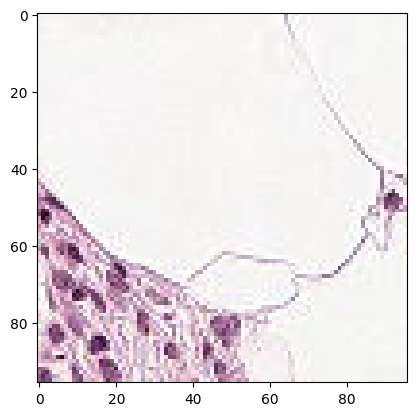

In [ ]:
# Show a sample image
img = mpimg.imread(df['image_path'][0])
plt.imshow(img)

In [ ]:
# Split into train and validation sets
train_df, val_df = train_test_split(df, test_size = 0.1)

# Create image generators
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, vertical_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)

# Create generators to read images from dataset directory
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col = 'image_path',
                                                    y_col = 'label',
                                                    target_size = (96, 96),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 32,
    class_mode = 'binary')


Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


### Flatten and Standardize Images

In [ ]:
# train_flatten = train_orig.reshape(train_orig.shape[0], -1).T
# train_x = train_flatten/255.
# print("train_x shape: " + str(train_x.shape))

train_x shape: (27648, 220025)


### Neural Networks

#### Keras Basic Model

In [ ]:
# config = [Dense(units = 10, activation='relu', input_dim = 27648),
#           Dense(units = 1, activation='sigmoid')]

# model = Sequential(config)

# model.summary()

#### Keras Model Build Function

In [ ]:
# nl = number of hidden layers
# nn = number of neurons in each hidden layer
# input_dim = number of input features
# output_dim = number of output features

# def mymodel(nl, nn, input_dim, output_dim):
#     model = Sequential([Dense(units = nn, activation='relu', input_dim = input_dim)])
#     for l in range(nl):
#         model.add(Dense(units = nn, activation='relu'))
#     model.add(Dense(units = output_dim, activation='sigmoid'))
#     return model

# model2 = mymodel(5, 4, 100, 1)

# print(model2.summary())

# model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### CNN Model Specification

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

### Compile the Model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train the Model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_df)//32,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = len(val_df)//32)

Epoch 1/10
6188/6188 [==============================] - 393s 64ms/step - loss: 0.4363 - accuracy: 0.8057 - val_loss: 0.3511 - val_accuracy: 0.8493
Epoch 2/10
6188/6188 [==============================] - 404s 65ms/step - loss: 0.3444 - accuracy: 0.8544 - val_loss: 0.3609 - val_accuracy: 0.8501
Epoch 3/10
6188/6188 [==============================] - 411s 66ms/step - loss: 0.3094 - accuracy: 0.8731 - val_loss: 0.2833 - val_accuracy: 0.8810
Epoch 4/10
6188/6188 [==============================] - 417s 67ms/step - loss: 0.2882 - accuracy: 0.8825 - val_loss: 0.2489 - val_accuracy: 0.8982
Epoch 5/10
6188/6188 [==============================] - 396s 64ms/step - loss: 0.2750 - accuracy: 0.8889 - val_loss: 0.2521 - val_accuracy: 0.8982
Epoch 6/10
6188/6188 [==============================] - 398s 64ms/step - loss: 0.2617 - accuracy: 0.8958 - val_loss: 0.2439 - val_accuracy: 0.9038
Epoch 7/10
6188/6188 [==============================] - 408s 66ms/step - loss: 0.2530 - accuracy: 0.9003 - val_loss: 0

### Monitor Performance

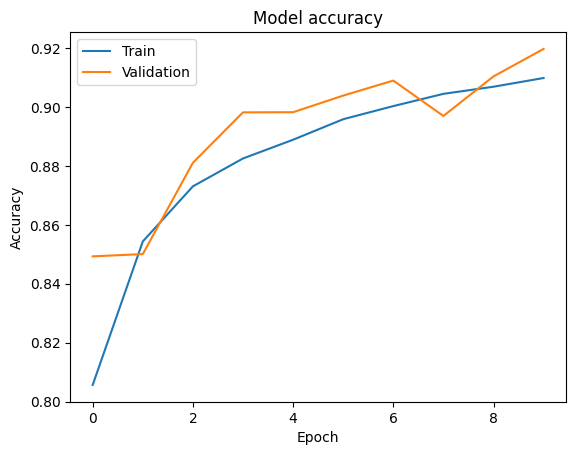

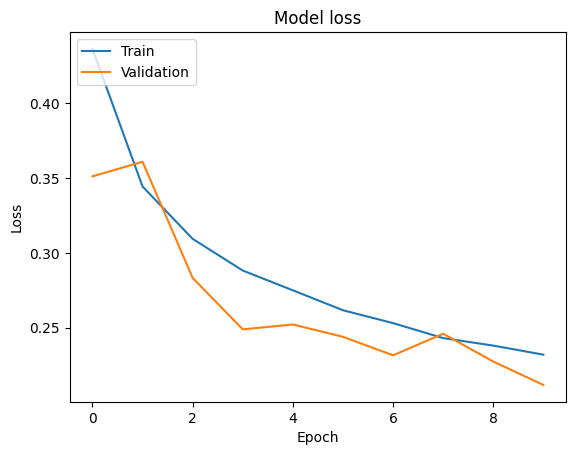

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
